# Building an Anime Recommendation System
Picture this, you're spending a lazy Sunday on the couch, watching the latest season of your favorite show on Netflix. Hours pass by and after binging till the last episode, you see a screen which recommends other shows you can continue watching. Alas, none of them are to your liking and now you have to scroll through countless other shows to find one you want to watch so you can continue your binge. One way your Sundays could be less stressful is if you had a good recommendation system which would save all that time you spent watching trailers. Through this project, I will be attempting to achieve exactly the same. I love watching anime but have a really tough time finding recommendations that I actually like or any recommendations at all, so I decided to get my own. The Recommendation system we'll be building today will be a user based system, i.e, it will recommend anime that users similar to me have liked based on viewing history and ratings. We will be using cosine similarity to determine similar users and even recommend the most liked anime to new users with no previous viewing history. At the end of the project we will be using it to provide recommendations based on my very own anime preferences.

## Contents
1. Exploratory Data Analysis
2. Builiding the Recommendation Model
3. Getting Recommendations from the Model

### 1. Exploratory Data Analysis
We will be using 3 datasets, one which contains details of all anime corresponding to their anime_id including their name, genre and other details. The second dataset contains interactions between all users and all anime they've watched corresponding to their user_id and anime_id along with the rating. If the user watched the anime but did not provide a rating, we get a value of -1. These two datasets were obtained from Kaggle. Our last dataset contains my own ratings for anime that I have watched and we will be using this to get my own recommendations.

In [1]:
# Loading Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
# Reading the Required Datasets
anime = pd.read_csv("Anime_Dataset/anime.csv")
rating = pd.read_csv("Anime_Dataset/rating.csv")
my_anime = pd.read_csv("Anime_Dataset/My_Anime.csv")

In [3]:
# Setting Seaborn Theme for Charts
sns.set_theme()

In [4]:
# Summary of Anime Details Dataset
print(anime.shape)
print(anime.info())
anime.head(10)

(12294, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


In [5]:
# Checking Unique Values of No. of Episodes
anime['episodes'].unique()

array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       'Unknown', '39', '101', '47', '50', '62', '33', '112', '23', '3',
       '94', '6', '8', '14', '7', '40', '15', '203', '77', '291', '120',
       '102', '96', '38', '79', '175', '103', '70', '153', '45', '5',
       '21', '63', '52', '28', '145', '36', '69', '60', '178', '114',
       '35', '61', '34', '109', '20', '9', '49', '366', '97', '48', '78',
       '358', '155', '104', '113', '54', '167', '161', '42', '142', '31',
       '373', '220', '46', '195', '17', '1787', '73', '147', '127', '16',
       '19', '98', '150', '76', '53', '124', '29', '115', '224', '44',
       '58', '93', '154', '92', '67', '172', '86', '30', '276', '59',
       '72', '330', '41', '105', '128', '137', '56', '55', '65', '243',
       '193', '18', '191', '180', '91', '192', '66', '182', '32', '164',
       '100', '296', '694', '95', '68', '117', '151', '130',

We see here that we have some 'Unknown' values which is converting the episodes column to object type. To convert it into a column of integer type, we will be dropping these rows from the dataset.

In [6]:
# Dropping Rows with 'Unknown' and Converting Column Type
anime_viz = anime.dropna()
anime_viz = anime_viz[anime_viz['episodes'] != "Unknown"]
anime_viz['episodes'] = pd.to_numeric(anime_viz['episodes'])

In [7]:
# Checking for Null Values
anime_viz = anime_viz.reset_index(drop=True)
anime_viz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11830 entries, 0 to 11829
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  11830 non-null  int64  
 1   name      11830 non-null  object 
 2   genre     11830 non-null  object 
 3   type      11830 non-null  object 
 4   episodes  11830 non-null  int64  
 5   rating    11830 non-null  float64
 6   members   11830 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 647.1+ KB


From looking at the genre column from the head of the dataset, we see that each anime title has multiple genres. If we want to look at data corresponing to each individual genre, we will have to split the column values.

In [8]:
# Getting List of All Genres from 'genre' Column
anime_genre = []
for genre in anime_viz['genre']:
    anime_genre = anime_genre + genre.split(', ')

Now we can find how many times each genre occurs in the dataset to find the most frequent genres.

In [9]:
# Getting Frequency of Each Genre in the Dataset
from collections import Counter

genre_list = list(Counter(anime_genre).keys())
genre_freq = list(Counter(anime_genre).values())

print(genre_list)
print(genre_freq)

genre_dist = pd.DataFrame()
genre_dist['genre'] = genre_list
genre_dist['freq'] = genre_freq

['Drama', 'Romance', 'School', 'Supernatural', 'Action', 'Adventure', 'Fantasy', 'Magic', 'Military', 'Shounen', 'Comedy', 'Historical', 'Parody', 'Samurai', 'Sci-Fi', 'Thriller', 'Sports', 'Super Power', 'Space', 'Slice of Life', 'Mecha', 'Music', 'Mystery', 'Seinen', 'Martial Arts', 'Vampire', 'Shoujo', 'Horror', 'Police', 'Psychological', 'Demons', 'Ecchi', 'Josei', 'Shounen Ai', 'Game', 'Dementia', 'Harem', 'Cars', 'Kids', 'Shoujo Ai', 'Hentai', 'Yaoi', 'Yuri']
[1972, 1436, 1164, 993, 2748, 2293, 2219, 742, 415, 1669, 4483, 787, 397, 145, 2028, 86, 527, 445, 376, 1180, 927, 832, 482, 530, 258, 100, 587, 360, 194, 226, 287, 627, 52, 62, 170, 238, 312, 71, 1550, 54, 1099, 37, 41]


Text(0, 0.5, 'Frequency')

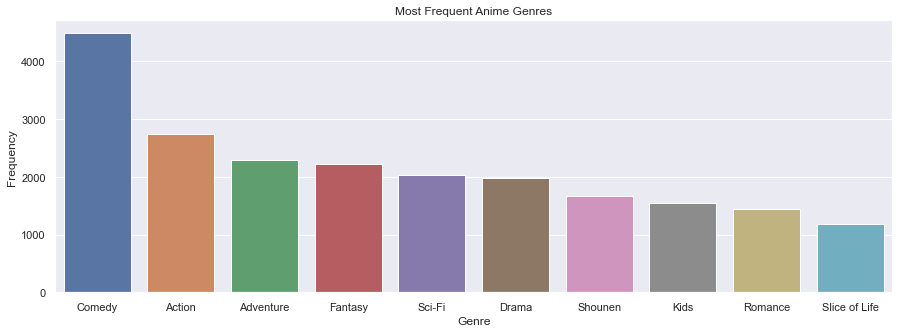

In [10]:
# Plotting Frequency of Occurence of Top 10 Genres
genre_dist = genre_dist.sort_values('freq',ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(x=genre_dist['genre'][0:10],y=genre_dist['freq'][0:10])
plt.title('Most Frequent Anime Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')

We see from the above chart that Comedy seems to be the most frequently occuring genre among anime titles. Lets keep this in mind and check further on if this high frequency translates into poularity among viewers.

To find average rating and total no. of users for each genre, we will be parsing through the entire dataset. We will also be creating another dataset containing all rating and no. of members values for each genre so we can see their distribution.

In [11]:
# Finding Average Rating and Total No. of Members for Each Genre
genre_agg = []
genre_full = []
for genre in genre_list:
    rating_sum = 0
    members_sum = 0
    count = 0
    for i in range(anime_viz.shape[0]):
        if (genre in anime_viz['genre'][i].split(', ')):
            rating_sum += anime_viz['rating'][i]
            members_sum += anime_viz['members'][i]
            count += 1
            genre_full.append([genre,anime_viz['rating'][i],anime_viz['members'][i]])
    genre_agg.append([genre,rating_sum/count,members_sum])

genre_agg = pd.DataFrame(genre_agg,columns=['genre','avg_rating','members'])
genre_full = pd.DataFrame(genre_full,columns=['genre','rating','members'])

Text(0, 0.5, 'Rating')

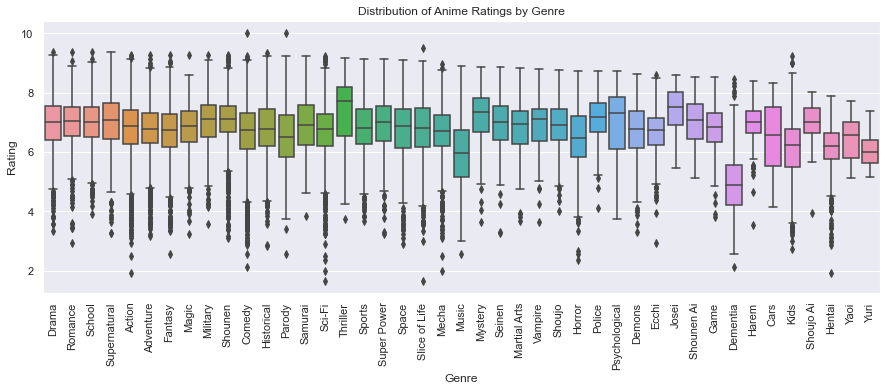

In [12]:
# Plotting Boxplots for Distribution of Rating Across All Genres
plt.figure(figsize=(15,5))
ax = sns.boxplot(x='genre',y='rating',data=genre_full)
ax.set_xticklabels(genre_full['genre'].unique(),rotation=90)
plt.title('Distribution of Anime Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('Rating')

By looking at the distribution of rating across genres we can see that Josei and Thriller genres have the highest mean ratings while Josei has a small and Thriller has a larger interquartile range. This tells us that even though both genres have similar average ratings, Josei received high ratings more consistently. We also see that Cars genre has the largest interquartile range which tells us that our users have a wide range of opinions on this genre.

Text(0, 0.5, 'No. of Members')

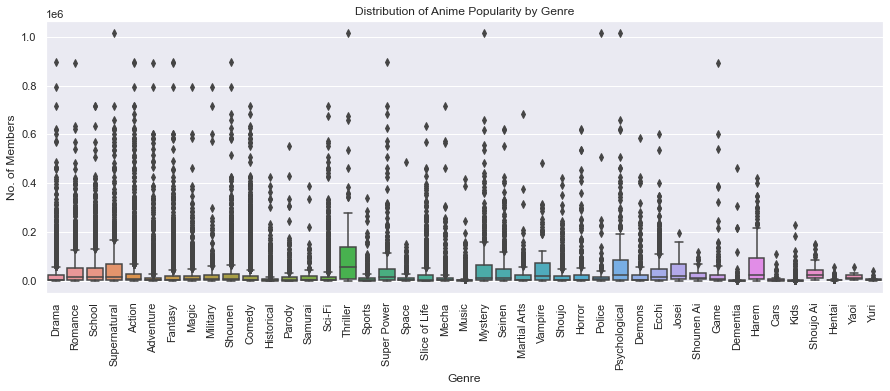

In [13]:
# Plotting Boxplots for Distribution of No. of Members Across All Genres
plt.figure(figsize=(15,5))
ax = sns.boxplot(x='genre',y='members',data=genre_full)
ax.set_xticklabels(genre_full['genre'].unique(),rotation=90)
plt.title('Distribution of Anime Popularity by Genre')
plt.xlabel('Genre')
plt.ylabel('No. of Members')

We dont get a lot of information from the distribution of no. of members by genre as it is mostly offset by outliers.

Text(0, 0.5, 'Average Rating')

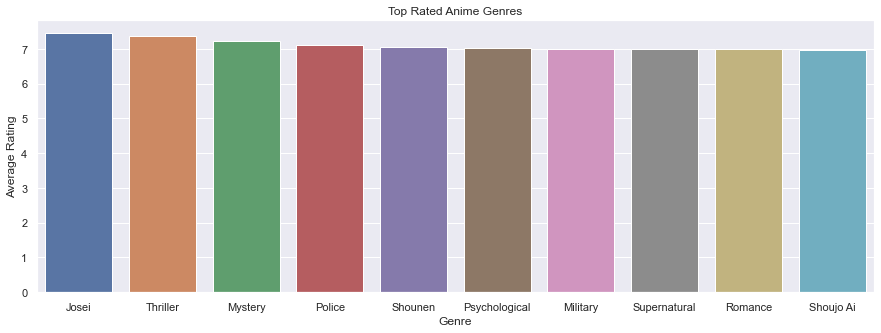

In [14]:
# Plotting the Top 10 Anime Genres by Rating
genre_agg_1 = genre_agg.sort_values('avg_rating',ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(x=genre_agg_1['genre'][0:10],y=genre_agg_1['avg_rating'][0:10])
plt.title('Top Rated Anime Genres')
plt.xlabel('Genre')
plt.ylabel('Average Rating')

As we saw from our boxplot for rating, Josei and Thriller are the genres with the highest ratings.

Text(0, 0.5, 'No. of Members')

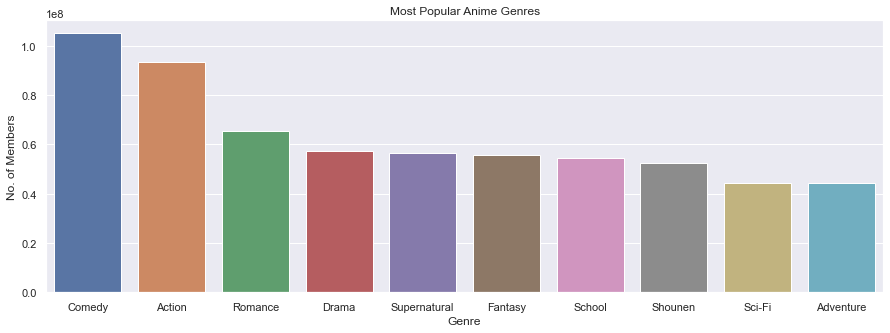

In [15]:
# Plotting the Top 10 Anime Genres by No. of Members
genre_agg_2 = genre_agg.sort_values('members',ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(x=genre_agg_2['genre'][0:10],y=genre_agg_2['members'][0:10])
plt.title('Most Popular Anime Genres')
plt.xlabel('Genre')
plt.ylabel('No. of Members')

Earlier we saw that Comedy was the most frequently occuring genre. That might have contributed to Comedy being the most popular anime genre.

Text(0, 0.5, 'Rating')

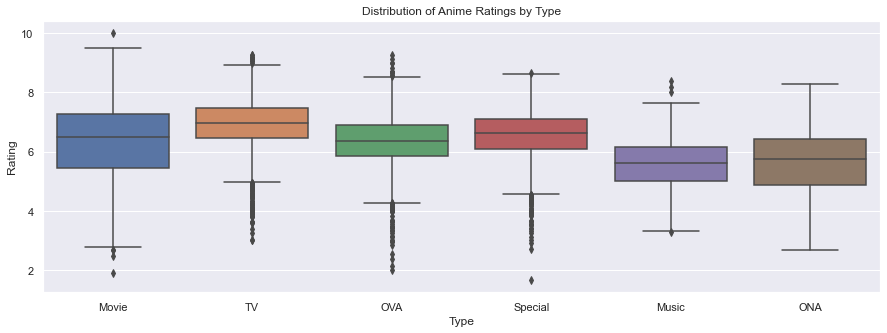

In [16]:
# Plotting Boxplots for Distribution of Rating Across All Types
plt.figure(figsize=(15,5))
sns.boxplot(x='type',y='rating',data=anime_viz)
plt.title('Distribution of Anime Ratings by Type')
plt.xlabel('Type')
plt.ylabel('Rating')

Most of the anime Types seem to have similar ranges of ratings.

Text(0, 0.5, 'No. of Members')

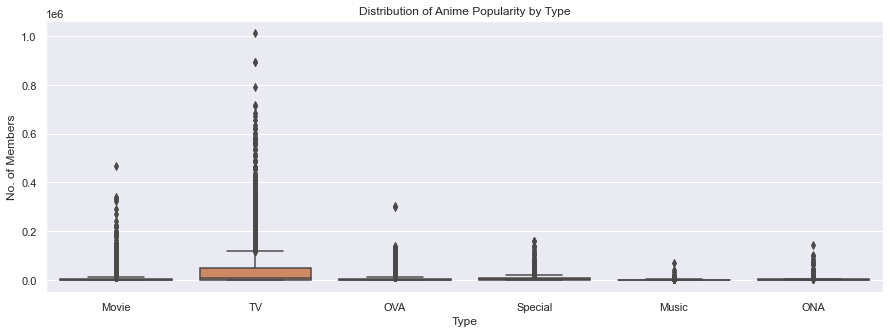

In [17]:
# Plotting Boxplots for Distribution of No. of Members Across All Genres
plt.figure(figsize=(15,5))
sns.boxplot(x='type',y='members',data=anime_viz)
plt.title('Distribution of Anime Popularity by Type')
plt.xlabel('Type')
plt.ylabel('No. of Members')

From this boxplot we can see that TV type anime clearly has the highest no. of overall members.

In [18]:
# Finding Average Rating and Total No. of Members for Each Type
type_dist = anime_viz.groupby('type').aggregate({'rating':'mean','members':'sum'})

In [19]:
type_dist

,rating,members
type,,
Movie,6.334486,23863921
Music,5.588665,640140
ONA,5.640479,2696238
OVA,6.371087,19689166
Special,6.525453,12835977
TV,6.929487,159259721


Text(0, 0.5, 'Average Rating')

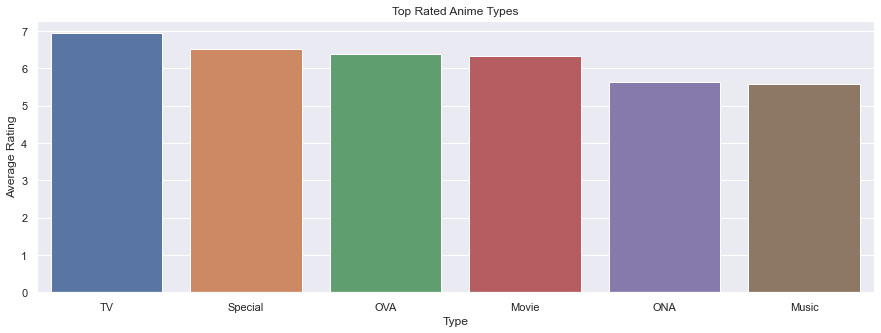

In [20]:
# Plotting the Top 10 Anime Types by Rating
type_dist_1 = type_dist.sort_values('rating',ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(x=type_dist_1.index,y=type_dist_1['rating'])
plt.title('Top Rated Anime Types')
plt.xlabel('Type')
plt.ylabel('Average Rating')

Text(0, 0.5, 'No. of Members')

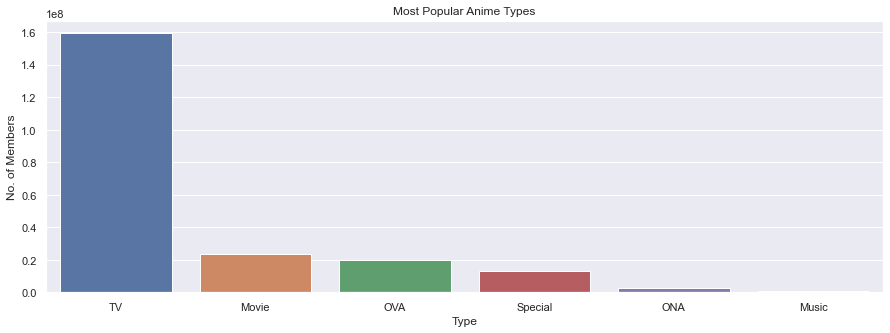

In [21]:
# Plotting the Top 10 Anime Types by No. of Members
type_dist_2 = type_dist.sort_values('members',ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(x=type_dist_2.index,y=type_dist_2['members'])
plt.title('Most Popular Anime Types')
plt.xlabel('Type')
plt.ylabel('No. of Members')

This plot just shows us what we saw from the boxplot of distribution of no. of members by Type in a cleaner manner.

Text(0, 0.5, 'Average Rating')

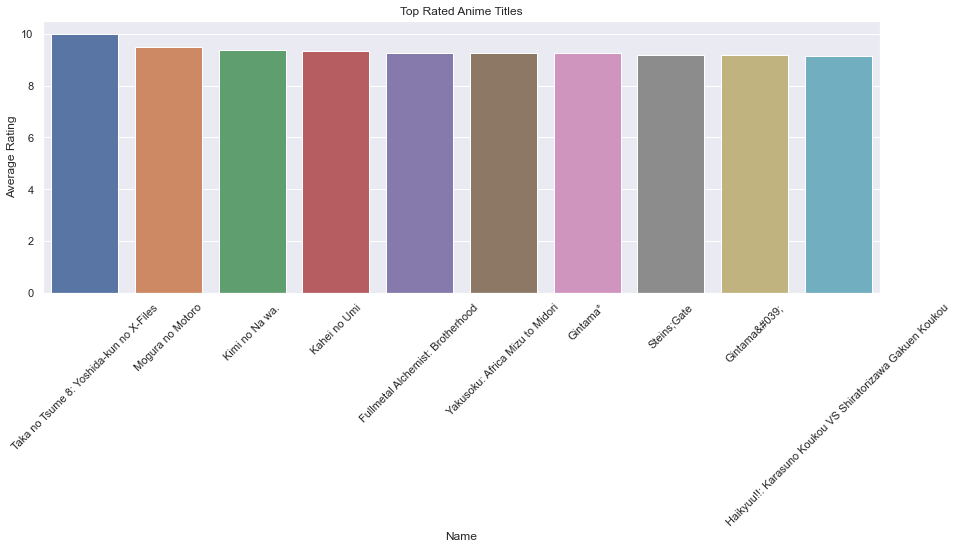

In [22]:
# Plotting the Top 10 Anime Titles by Rating
top_anime_1 = anime_viz.sort_values('rating',ascending=False)

plt.figure(figsize=(15,5))
ax = sns.barplot(x=top_anime_1['name'][0:10],y=top_anime_1['rating'][0:10])
ax.set_xticklabels(top_anime_1['name'][0:10],rotation = 45)
plt.title('Top Rated Anime Titles')
plt.xlabel('Name')
plt.ylabel('Average Rating')

Text(0, 0.5, 'No. of Members')

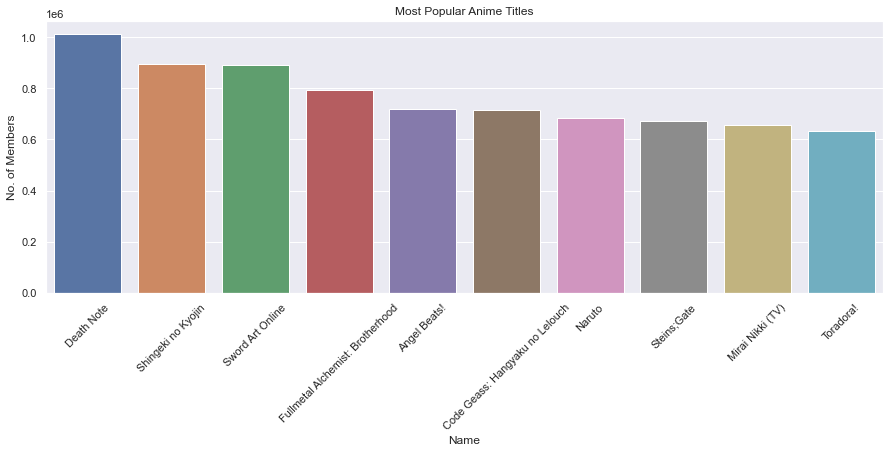

In [23]:
# Plotting the Top 10 Anime Titles by No. of Members
top_anime_2 = anime_viz.sort_values('members',ascending=False)

plt.figure(figsize=(15,5))
ax = sns.barplot(x=top_anime_2['name'][0:10],y=top_anime_2['members'][0:10])
ax.set_xticklabels(top_anime_2['name'][0:10],rotation = 45)
plt.title('Most Popular Anime Titles')
plt.xlabel('Name')
plt.ylabel('No. of Members')

From the above 2 plots we can see that Fullmetal Alchemist:Brotherhood and Steins;Gate are among the top 10 highest rated and most popular anime, hence they would be great choices for someone who is new to anime!

array([[<AxesSubplot:xlabel='episodes', ylabel='episodes'>,
        <AxesSubplot:xlabel='rating', ylabel='episodes'>,
        <AxesSubplot:xlabel='members', ylabel='episodes'>],
       [<AxesSubplot:xlabel='episodes', ylabel='rating'>,
        <AxesSubplot:xlabel='rating', ylabel='rating'>,
        <AxesSubplot:xlabel='members', ylabel='rating'>],
       [<AxesSubplot:xlabel='episodes', ylabel='members'>,
        <AxesSubplot:xlabel='rating', ylabel='members'>,
        <AxesSubplot:xlabel='members', ylabel='members'>]], dtype=object)

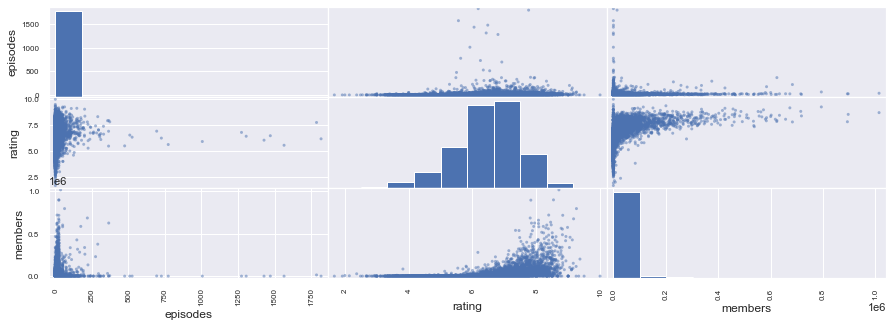

In [24]:
# Plotting a Scatter Matrix for Episodes, Rating and Members columns
anime_viz_scatter = anime_viz[['episodes','rating','members']]

pd.plotting.scatter_matrix(anime_viz_scatter,figsize=(15,5))

From the scatter-matrix we can see somewhat of an exponential relationship between rating and no. of members. We would probably be able to see a more linear relationship if we took logarithm of all values of no. of members. We would be able to use this relationship if we wanted to build a regression model to predict rating or no. of members if the other value was known.

In [25]:
# Summary of Dataset Containing User Ratings
print(rating.shape)
print(rating.info())
rating.head(10)

(7813737, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


In [26]:
# Summary of Dataset Containing My Ratings 
print(my_anime.shape)
print(my_anime.info())
my_anime.head(10)

(23, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   23 non-null     int64
 1   anime_id  23 non-null     int64
 2   rating    23 non-null     int64
dtypes: int64(3)
memory usage: 680.0 bytes
None


,user_id,anime_id,rating
0,99999,136,10
1,99999,30276,10
2,99999,32182,10
3,99999,245,10
4,99999,5114,9
5,99999,1535,9
6,99999,11061,9
7,99999,33255,9
8,99999,9253,9
9,99999,23755,9


In [27]:
# Joining My Ratings to Dataset with Ratings of All Other Users
rating = pd.concat([rating,my_anime])
rating = rating.reset_index(drop=True)

 8     1646029
-1     1476496
 7     1375290
 9     1254102
 10     955719
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
Name: rating, dtype: int64

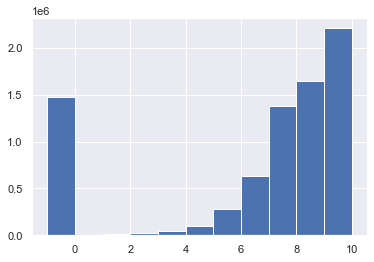

In [28]:
# Plotting Histogram for All Rating Values
plt.hist(rating['rating'],bins=11)
rating['rating'].value_counts()

In our dataset, a rating of -1 was assigned to those interactions where a user watched a given anime but did not give a rating. According to extremity bias, users tend to give ratings only when they have strong emotions that are either positive or negative towards what they have watched, hence we can assume a rating of 5 for the interactions where a rating was not given. This also helps us find similarity between users more accurately than if we had left them as -1 or set them to 0.

In [29]:
# Replacing all Ratings of -1 with 5
rating['rating'] = rating['rating'].replace([-1],5)

5     1759302
8     1646029
7     1375290
9     1254102
10     955719
6      637775
4      104291
3       41453
2       23150
1       16649
Name: rating, dtype: int64

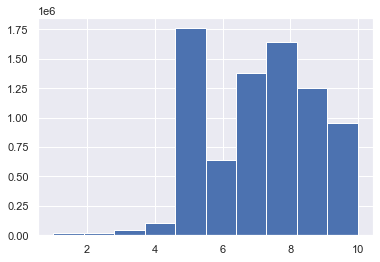

In [30]:
# Plotting Histogram for All Rating Values After Replacement of -1
plt.hist(rating['rating'],bins=10)
rating['rating'].value_counts()

### 2. Building the Recommendation Model
To build our recommendation model, we will first need to create an interaction matrix which contains rating values for interactions between each user_id and anime_id in the dataset. Once we have created the interaction matrix, we will be using cosine similarity to find similar users and use this data to generate recommendations.

In [31]:
# Fining No. of Unique Users and No. of Anime in Ratings Dataset
print("No. of unique users: ",len(rating['user_id'].unique()))
print("No. of unique anime: ",len(rating['anime_id'].unique()))

No. of unique users:  73516
No. of unique anime:  11202


In [32]:
# Grouping By Unique User in Case of Duplicates
rating = rating.groupby(['user_id','anime_id']).aggregate({'rating':'mean'})
rating = rating.reset_index()
rating.head(10)

,user_id,anime_id,rating
0,1,20,5.0
1,1,24,5.0
2,1,79,5.0
3,1,226,5.0
4,1,241,5.0
5,1,355,5.0
6,1,356,5.0
7,1,442,5.0
8,1,487,5.0
9,1,846,5.0


In [33]:
# Creating Interaction Matrix by Pivoting Ratings Table
int_matrix = rating.pivot(index='user_id',columns='anime_id',values='rating')
print(int_matrix.shape)
int_matrix.head(10)

(73516, 11202)


anime_id,1,5,6,7,8,15,16,17,18,19,...,34283,34324,34325,34349,34358,34367,34412,34475,34476,34519
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,8.0,NaN,NaN,6.0,NaN,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Replacing NaN Values with 0
int_matrix = int_matrix.fillna(0)
int_matrix.head(10)

anime_id,1,5,6,7,8,15,16,17,18,19,...,34283,34324,34325,34349,34358,34367,34412,34475,34476,34519
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,8.0,0.0,0.0,6.0,0.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Defining a Function for Most Similar Users and their Similarity Score
from sklearn.metrics.pairwise import cosine_similarity

def similar_users(user,interaction_matrix):
    
    similarity = []

    user_list = list(interaction_matrix.index)
    user_list_new = [j for j in user_list if j != user]
    
    for i in user_list_new:
        sim = cosine_similarity([interaction_matrix.loc[user]],[interaction_matrix.loc[i]])
        similarity.append((i,sim))

    similarity.sort(key=lambda x:x[1],reverse = True)

    most_similar_users = [tup[0] for tup in similarity]
    similarity_score = [tup[1] for tup in similarity]

    return most_similar_users,similarity_score

In [36]:
# Checking for Most Similar Users and their Similarity Score
sim1, sim2 = similar_users(1,int_matrix)
print("Users most similar to user 1: ",sim1[0:5])
print("Similarity score of users most similar to user 1: ",sim2[0:5])

Users most similar to user 1:  [1929, 15195, 14996, 18062, 42765]
Similarity score of users most similar to user 1:  [array([[0.52718683]]), array([[0.48748272]]), array([[0.48686499]]), array([[0.48628501]]), array([[0.48588986]])]


Now that we have a function that tells us which are the most similar users to the user_id in question, we can provide reccomendations by using the anime titles watched by the most similar user but not watched by the user themself. These recommendations will be in order of highest to lowest rating given by the similar user. If the no. of recommendations we get from the most similar user is not sufficient, we will move on to the next most similar user until we get enough numer of recommendations.

We will also keep in mind that we might have users with no previous watch history. For these new users we will be recommending anime that was most liked by existing users by taking the highest sum of rating across titles.

The function we create will be taking the user_id, number of recommendations required and the interaction matrix as an input and will be providing given number of anime_id recommendations as an output.

In [37]:
# Building a Function for Recommendations
def recommendations(user,num_reco,interaction_matrix):
    
    if list(int_matrix.index).count(user) > 0:
    
        sim_users = similar_users(user,interaction_matrix)[0]

        watched_anime = interaction_matrix.loc[user]
        watched_anime = watched_anime[watched_anime != 0]
        watched_anime = list(watched_anime.index)

        anime_recommendations = []

        for user_id in sim_users:

            if (len(anime_recommendations) < num_reco):

                similar_anime = interaction_matrix.loc[user_id].sort_values(ascending = False)
                similar_anime = similar_anime[similar_anime != 0]
                similar_anime = list(similar_anime.index)

                new_recommendations = [x for x in similar_anime if x not in watched_anime]
                anime_recommendations = anime_recommendations + new_recommendations

                watched_anime = watched_anime + new_recommendations

            else:
                break

        return anime_recommendations[:num_reco]
    
    else:
        
        most_popular_anime = pd.DataFrame(interaction_matrix.sum(axis=0),columns=['rating_sum'])
        most_popular_anime = most_popular_anime.sort_values('rating_sum',ascending=False)
        
        return list(most_popular_anime[:num_reco].index)

### 3. Getting Recommendations from the Model
Now that we have our function to provide given no. of recommendations, let us try it out on some user_ids.

First, lets try it on a user whos user_id is present in our rating dataset and hence would have a viewing and rating history.

In [38]:
# Recommendations for User with Watch History
sample_rec_1 = pd.merge(pd.DataFrame(recommendations(1929,10,int_matrix),columns=['anime_id']),anime,how='left')
sample_rec_1

,anime_id,name,genre,type,episodes,rating,members
0,6573,Darker than Black: Ryuusei no Gemini,"Action, Mystery, Sci-Fi, Super Power",TV,12,7.62,222243
1,16592,Danganronpa: Kibou no Gakuen to Zetsubou no Ko...,"Action, Horror, Mystery, Psychological",TV,13,7.49,298550
2,31043,Boku dake ga Inai Machi,"Mystery, Psychological, Seinen, Supernatural",TV,12,8.65,402381
3,14345,Btooom!,"Action, Psychological, Sci-Fi, Seinen",TV,12,7.68,329561
4,14513,Magi: The Labyrinth of Magic,"Action, Adventure, Fantasy, Magic, Shounen",TV,25,8.24,317513
5,5530,Pandora Hearts,"Adventure, Fantasy, Mystery, Shounen, Supernat...",TV,25,7.92,229567
6,32998,91 Days,"Action, Drama, Historical",TV,12,7.93,140604
7,9750,Itsuka Tenma no Kuro Usagi,"Comedy, Ecchi, Romance, Shounen, Supernatural,...",TV,12,6.83,73555
8,31404,Netoge no Yome wa Onnanoko ja Nai to Omotta?,"Comedy, Ecchi, Game, Romance, School",TV,12,7.17,137102
9,11433,Ano Natsu de Matteru,"Comedy, Drama, Romance, Sci-Fi, Slice of Life",TV,12,7.70,169718


Next, lets see what recommendations we get when we provide a user_id thats not in our rating dataset and hence they would be a new user.

In [39]:
# Recommendations for New User
sample_rec_2 = pd.merge(pd.DataFrame(recommendations(74000,10,int_matrix),columns=['anime_id']),anime,how='left')
sample_rec_2

,anime_id,name,genre,type,episodes,rating,members
0,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
1,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
2,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
3,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
4,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
5,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
6,226,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511
7,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888
8,121,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,51,8.33,600384
9,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


Finally, let's use our function on my user_id which would return recommendations based on my viewing and rating history.

In [40]:
# Recommendations for My Watch History
my_anime_recos = pd.merge(pd.DataFrame(recommendations(99999,10,int_matrix),columns=['anime_id']),anime,how='left')
my_anime_recos

,anime_id,name,genre,type,episodes,rating,members
0,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888
1,10087,Fate/Zero,"Action, Fantasy, Supernatural",TV,13,8.51,453630
2,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
3,11741,Fate/Zero 2nd Season,"Action, Fantasy, Supernatural, Thriller",TV,12,8.73,340973
4,2167,Clannad,"Comedy, Drama, Romance, School, Slice of Life,...",TV,23,8.30,566690
5,22297,Fate/stay night: Unlimited Blade Works,"Action, Fantasy, Magic, Shounen, Supernatural",TV,12,8.42,267484
6,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
7,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
8,25303,Haikyuu!! OVA,"Shounen, Sports",OVA,2,7.93,30063
9,28701,Fate/stay night: Unlimited Blade Works 2nd Season,"Action, Fantasy, Magic, Shounen, Supernatural",TV,13,8.45,205987


Damn! Now I finally know what I'm going to watch in the next few weeks and lets hope it doesn't let me down and all this effort of building a recommendation engine pays off!

This project was another effort of mine at understanding Data Science concepts by applying them to real life problems and it definitely helped me understand how to look at data more closely and how big platforms like Youtube and Netflix approach the problem of generating good recommendations.